---
# Advanced PyTorch Tutorial
## University of Tehran, School of ECE, Neural Networks Course, Spring 2023
### Instructor: Dr. Ahmad Kalhor, Teaching Assistant: <a href="mailto:mahyar.maleki@ut.ac.ir">Mahyar Maleki</a>

---

### Importing Libraries

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from PIL import Image
import cv2
import glob
import os

#### Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Dataset

## Exploring Dataset

Link to Dataset: [FashinMNIST Link](https://drive.google.com/drive/folders/1RckIKlh6GaoPTU_YeIOph_BwwY0qXQyj?usp=share_link)

In [ ]:
DIR_TRAIN = "/content/drive/MyDrive/fashionmnist/train/"
DIR_TEST = "/content/drive/MyDrive/fashionmnist/test/"

In [ ]:
classes = os.listdir(DIR_TRAIN)
print("Total Classes: ", len(classes))

train_imgs = []
test_imgs  = []
for _class in classes:
    train_imgs += glob.glob(DIR_TRAIN + _class + '/*.jpg')
    test_imgs += glob.glob(DIR_TEST + _class + '/*.jpg')


print("\nTotal train images: ", len(train_imgs))
print("Total test images: ", len(test_imgs))

Total Classes:  10

Total train images:  60000
Total test images:  10000


## Loading Dataset

#### Transformations

In [ ]:
Transforms = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize(mean=0.5, std=0.5)])

#### Method 1 ( Using Torchvision Datasets )

In [ ]:
train_dataset = torchvision.datasets.FashionMNIST(
    root = "data", # where to download data to
    train = True, # get training data
    download = True, # download data if it doesn't exist on disk
    transform = Transforms # images come as PIL format, we want to turn into Torch tensors
)

test_dataset = torchvision.datasets.FashionMNIST(
    root = "data",
    train = False, # get test data
    download = True,
    transform = Transforms
)

#### Method 2 ( Using ImageFolder Class )

In [ ]:
train_dataset = ImageFolder(root = DIR_TRAIN, transform = Transforms)
test_dataset = ImageFolder(root = DIR_TEST, transform = Transforms)

#### Method 3 ( Using Dataset Class )

In [ ]:
class FashionMNISTDataset(Dataset):
    
    def __init__(self, imgs_list, classes, transforms):
        
        self.imgs_list = imgs_list
        self.class_to_int = {classes[i] : i for i in range(len(classes))}
        self.transforms = transforms
        
        
    def __getitem__(self, index):

        # Image path
        image_path = self.imgs_list[index]
        
        # Reading image
        image = Image.open(image_path)
        
        # Retriving class label
        label = image_path.split("/")[-2]
        label = self.class_to_int[label]
        
        # Applying transforms on image
        image = self.transforms(image)
        
        return image, label
        

    def __len__(self):
        return len(self.imgs_list)

In [ ]:
train_dataset = FashionMNISTDataset(train_imgs, classes, Transforms)
test_dataset = FashionMNISTDataset(test_imgs, classes, Transforms)

## Creating Dataloader

In [ ]:
train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = 32,
    num_workers = 2,
    shuffle = True
)

test_dataloader = DataLoader(
    dataset = test_dataset,
    batch_size = 32,
    num_workers = 2,
)

## Showing a sample

In [ ]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 0


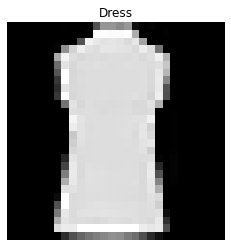

In [ ]:
img, label = train_features_batch[0], train_labels_batch[0]
mean, std = 0.5, 0.5
img = std * img + mean
plt.imshow(img.permute(1, 2, 0), cmap='gray')
plt.title(classes[label])
plt.axis("Off");
print(f"Image size: {img.shape}")
print(f"Label: {label}")

# 2. Building a Convolutional Neural Network (CNN)

![image.png](https://www.upgrad.com/blog/wp-content/uploads/2020/12/1-4.png)

#### Kernel Size

Choosing an appropriate kernel size will be dependent on your task and dataset, but generally, smaller kernel sizes lead to better performance for the image classification task because an architecture designer is able to stack more and more layers together to learn more and more complex features

![image.png](https://mlnotebook.github.io/img/CNN/convExample.png)

#### Stride

Indicates how many pixels the kernel should be shifted over at a time

`



![image.png](https://editor.analyticsvidhya.com/uploads/33383str.jpg)

#### Padding

Padding conserves data at the borders of activation maps, which leads to better performance, and it can help preserve the input's spatial size, which allows an architecture designer to build depper, higher performing networks

,

![image.png](https://img-blog.csdnimg.cn/2020090604393713.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L0xpbmxpNTIyMzYyMjQy,size_16,color_FFFFFF,t_70)

#### Pooling

It has the purpose of gradually decreasing the spatial extent of the network, which reduces the parameters and overall computation of the network

![image.png](https://www.researchgate.net/publication/333593451/figure/fig2/AS:765890261966848@1559613876098/Illustration-of-Max-Pooling-and-Average-Pooling-Figure-2-above-shows-an-example-of-max.png)

---

[CNN Explainer](https://poloclub.github.io/cnn-explainer/)



#### Network Structure

In [ ]:
# Create a convolutional neural network 
class CNN_Model(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        
        self.CNN_block = nn.Sequential(
            nn.Conv2d(input_shape,  hidden_units, kernel_size = 3, stride = 1, padding = 1), 
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = hidden_units*14*14, out_features = output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.CNN_block(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x


In [ ]:
model = CNN_Model(input_shape=1, hidden_units=10, output_shape=len(classes))
model

CNN_Model(
  (CNN_block): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1960, out_features=10, bias=True)
  )
)

In [ ]:
random_sample = torch.randn((1, 1, 28, 28))
model(random_sample).shape

torch.Size([1, 10])

# 3. Training

#### Train Function

In [ ]:
def train_step(model,
               data_loader,
               loss_fn,
               optimizer,
               accuracy_fn,
               device):
    
    # Send model to GPU
    model.to(device)
    train_loss, train_acc, counter = 0, 0, 0
    with tqdm(data_loader, desc ="  train") as train_tqdm:
        for X, y in train_tqdm:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            y_pred = model(X)

            # 2. Calculate loss
            loss = loss_fn(y_pred, y)
            train_loss += loss
            train_acc += accuracy_fn(true=y.cpu(),
                                     pred=y_pred.cpu())
            counter += 1
            train_tqdm.set_postfix(train_acc=train_acc/counter, train_loss=train_loss.item()/counter, refresh=True)

            # 3. Optimizer zero grad
            optimizer.zero_grad()

            # 4. Loss backward
            loss.backward()

            # 5. Optimizer step
            optimizer.step()

        # Calculate loss and accuracy per epoch and print out what's happening
        train_loss /= len(data_loader)
        train_acc /= len(data_loader)
        
    return train_loss.item(), train_acc


#### Test Function

In [ ]:
def test_step(model,
              data_loader,
              loss_fn,
              accuracy_fn,
              device):
    
    # Send model to GPU
    model.to(device)

    # put model in eval mode
    model.eval() 
    test_loss, test_acc, counter = 0, 0, 0
    with tqdm(data_loader, desc ="   test") as test_tqdm:
        for X, y in test_tqdm:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(true=y.cpu(),
                                    pred=test_pred.cpu())
            counter += 1
            test_tqdm.set_postfix(train_acc=test_acc/counter, train_loss=test_loss.item()/counter, refresh=True)

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc  /= len(data_loader)
            
    return test_loss.item(), test_acc

## Training

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def accuracy_fn(true, pred):
    pred = F.softmax(pred, dim = 1)
    true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1.)
    acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
    acc = float((100 * acc.sum()) / len(acc))
    return round(acc, 4)

In [ ]:
# Measure time
from timeit import default_timer as timer

train_epoch_loss = []
train_epoch_accuracy = []
test_epoch_loss = []
test_epoch_accuracy = []

train_time_start = timer()

epochs = 20
for epoch in range(epochs):
    print("EPOCH {}/{} :".format(epoch +1, epochs))
    train_loss, train_acc = train_step(data_loader=train_dataloader,
                                              model=model, 
                                              loss_fn=loss_fn,
                                              optimizer=optimizer,
                                              accuracy_fn=accuracy_fn,
                                              device=device
                                              )
    test_loss, test_acc = test_step(data_loader=test_dataloader,
                                    model=model,
                                    loss_fn=loss_fn,
                                    accuracy_fn=accuracy_fn,
                                    device=device
                                    )
    
    train_epoch_loss.append(train_loss)
    train_epoch_accuracy.append(train_acc)
    test_epoch_loss.append(test_loss)
    test_epoch_accuracy.append(test_acc)

train_time_end = timer()
total_time = train_time_end - train_time_start
print(f"\n\nTrain time: {total_time:.3f} seconds")

EPOCH 1/20 :


   test: 100%|██████████| 313/313 [00:03<00:00, 78.96it/s, train_acc=81.6, train_loss=0.517]


EPOCH 2/20 :


   test: 100%|██████████| 313/313 [00:03<00:00, 78.81it/s, train_acc=83.7, train_loss=0.45]


EPOCH 3/20 :


   test: 100%|██████████| 313/313 [00:04<00:00, 69.70it/s, train_acc=85.2, train_loss=0.415]


EPOCH 4/20 :


   test: 100%|██████████| 313/313 [00:05<00:00, 58.35it/s, train_acc=86, train_loss=0.393]


EPOCH 5/20 :


   test: 100%|██████████| 313/313 [00:04<00:00, 74.02it/s, train_acc=86.3, train_loss=0.381]


EPOCH 6/20 :


   test: 100%|██████████| 313/313 [00:03<00:00, 79.78it/s, train_acc=87.2, train_loss=0.37]


EPOCH 7/20 :


   test: 100%|██████████| 313/313 [00:03<00:00, 78.51it/s, train_acc=87.7, train_loss=0.353]


EPOCH 8/20 :


   test: 100%|██████████| 313/313 [00:04<00:00, 68.36it/s, train_acc=87.4, train_loss=0.351]


EPOCH 9/20 :


   test: 100%|██████████| 313/313 [00:05<00:00, 57.95it/s, train_acc=87.9, train_loss=0.345]


EPOCH 10/20 :


   test: 100%|██████████| 313/313 [00:04<00:00, 71.05it/s, train_acc=87.6, train_loss=0.356]


EPOCH 11/20 :


   test: 100%|██████████| 313/313 [00:03<00:00, 79.36it/s, train_acc=88.5, train_loss=0.336]


EPOCH 12/20 :


   test: 100%|██████████| 313/313 [00:03<00:00, 79.73it/s, train_acc=89, train_loss=0.321]


EPOCH 13/20 :


   test: 100%|██████████| 313/313 [00:04<00:00, 69.78it/s, train_acc=89.2, train_loss=0.319]


EPOCH 14/20 :


   test: 100%|██████████| 313/313 [00:05<00:00, 57.61it/s, train_acc=88.5, train_loss=0.326]


EPOCH 15/20 :


   test: 100%|██████████| 313/313 [00:04<00:00, 72.47it/s, train_acc=89.2, train_loss=0.317]


EPOCH 16/20 :


   test: 100%|██████████| 313/313 [00:04<00:00, 78.20it/s, train_acc=89, train_loss=0.308]


EPOCH 17/20 :


   test: 100%|██████████| 313/313 [00:04<00:00, 75.98it/s, train_acc=89.4, train_loss=0.304]


EPOCH 18/20 :


   test: 100%|██████████| 313/313 [00:04<00:00, 67.23it/s, train_acc=89.1, train_loss=0.308]


EPOCH 19/20 :


   test: 100%|██████████| 313/313 [00:05<00:00, 57.71it/s, train_acc=89.2, train_loss=0.302]


EPOCH 20/20 :


   test: 100%|██████████| 313/313 [00:03<00:00, 78.57it/s, train_acc=89.3, train_loss=0.303]




Train time: 685.353 seconds


#### Saving Model

In [ ]:
torch.save(model.state_dict(), 'saved_model')

# 4. Evaluation

#### Loss & Accuracy Plots

In [ ]:
def accloss_plots(train_loss=train_epoch_loss, 
                  test_loss=test_epoch_loss, 
                  train_acc=train_epoch_accuracy, 
                  test_acc=test_epoch_accuracy):
  
    num_epochs = len(train_loss)
    plt.figure(figsize=(13,5))
    plt.subplot(121)
    plt.plot(train_loss, 'r', label='Train')
    plt.plot(test_loss , 'g', label='Test')
    plt.xlabel('Epochs', fontsize=10, labelpad=8)
    plt.title('Loss', fontsize=25, pad=15)
    plt.grid()
    plt.legend()
    sns.despine()
    plt.subplot(122)
    plt.plot(train_acc, 'r', label='Train')
    plt.plot(test_acc, 'g', label='Test')
    plt.xlabel('Epochs', fontsize=10, labelpad=8)
    plt.title('Accuracy', fontsize=25, pad=15)
    plt.tight_layout(pad=3)
    plt.grid()
    plt.legend()
    sns.despine()
    plt.show();

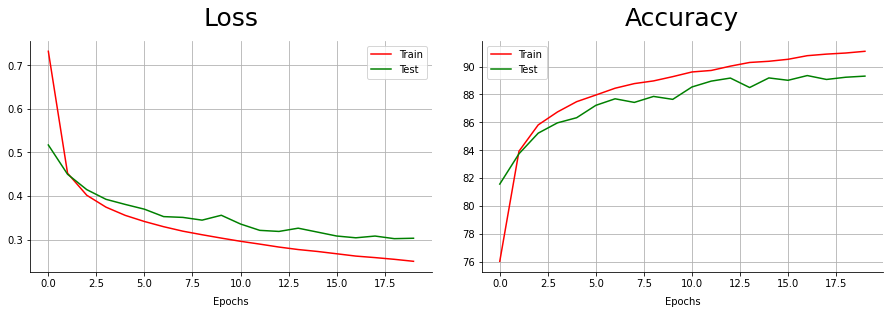

In [ ]:
accloss_plots()

#### Make prediction

In [ ]:
def make_predictions(model, data, device = device):
    pred_probs = []
    model.to(device)
    model.eval()
    for sample in data:
        # Prepare sample
        sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

        # Forward pass (model outputs raw logit)
        pred_logit = model(sample)

        # Get prediction probability (logit -> prediction probability)
        pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

        # Get pred_prob off GPU for further calculations
        pred_probs.append(pred_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [ ]:
import random
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_dataset), k=9):
    test_samples.append(sample)
    test_labels.append(label)

In [ ]:
# Make predictions on test samples with model
pred_probs = make_predictions(model=model, data=test_samples)

# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)

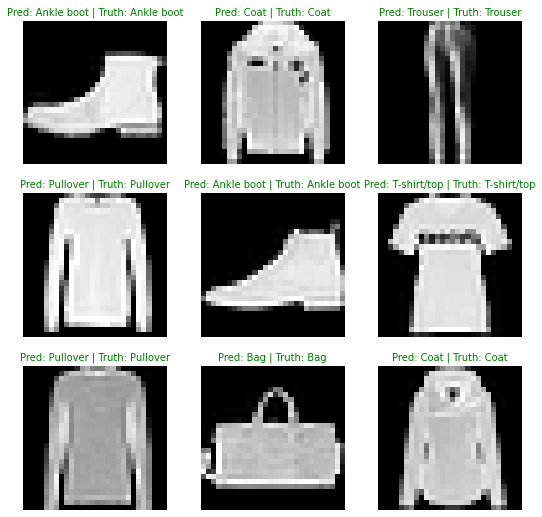

In [ ]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    # Create a subplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the target image
    plt.imshow(sample.squeeze(), cmap="gray")

    # Find the prediction label (in text form, e.g. "Sandal")
    pred_label = test_dataset.classes[pred_classes[i]]

    # Get the truth label (in text form, e.g. "T-shirt")
    truth_label = test_dataset.classes[test_labels[i]] 

    # Create the title text of the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"
    
    # Check for equality and change title colour accordingly
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g") # green text if correct
    else:
        plt.title(title_text, fontsize=10, c="r") # red text if wrong
    plt.axis(False);

#### Confusion Matrix

In [ ]:
y_preds = []
model.eval()
for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)

    # Do the forward pass
    y_logit = model(X)

    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)

    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
    
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions: 100%|██████████| 313/313 [00:02<00:00, 109.28it/s]


In [ ]:
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(y_true=test_dataset.targets,
                      y_pred=y_pred_tensor)
CM

array([[790,   0,  17,  36,   8,   2, 134,   0,  13,   0],
       [  0, 976,   1,  14,   5,   0,   2,   0,   2,   0],
       [ 15,   1, 792,  12, 111,   0,  65,   0,   4,   0],
       [ 11,   8,   8, 915,  25,   0,  30,   0,   3,   0],
       [  1,   0,  21,  35, 900,   0,  42,   0,   1,   0],
       [  0,   0,   0,   0,   0, 980,   0,  16,   0,   4],
       [ 93,   2,  60,  35, 111,   0, 685,   0,  14,   0],
       [  0,   0,   0,   0,   0,  15,   0, 972,   2,  11],
       [  3,   3,   1,   6,   1,   1,   2,   5, 978,   0],
       [  0,   0,   0,   0,   0,   9,   1,  45,   1, 944]])

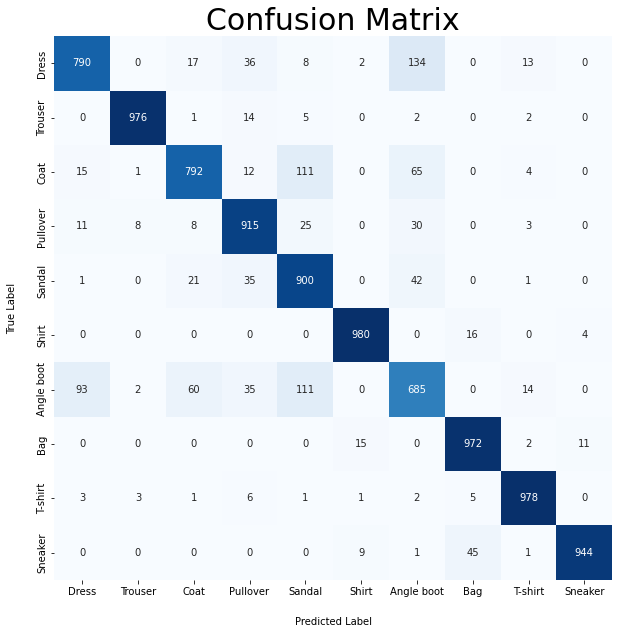

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(CM, cmap='Blues', annot=True, cbar=False, fmt=".0f",
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label', labelpad=20)
plt.ylabel('True Label', labelpad=20)
plt.title('Confusion Matrix', fontsize=30);

---
# Any Questions?
##### E-mail: mahyar.maleki@ut.ac.ir
##### Telegram_ID: @mhyr76

---